# Transfer learning and fine-tuning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory


## Download and preprocess the data

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)



68608000/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.


In [3]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)


Found 1000 files belonging to 2 classes.


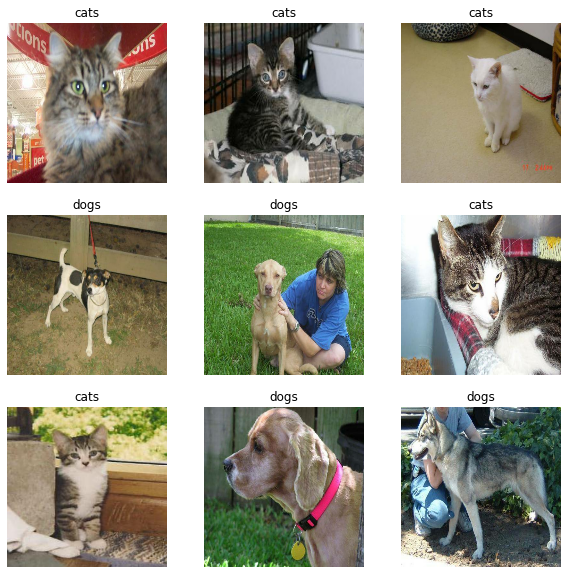

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The original dataset does not contain a test set, so we will create one. We will use 20% of the validation set and move them to a test set.

In [5]:
# Whats the number of batches available?
val_batches = tf.data.experimental.cardinality(validation_dataset)
print('Number of available batches: %d' % val_batches)

Number of available batches: 32


In [6]:
# We take 20%
test_dataset = validation_dataset.take(val_batches // 5)
validation_Dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 32
Number of test batches: 6


## Configure dataset performance

In [7]:
# Set up augmentation layers
data_augmentation = tf.keras.Sequential([
                                         tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                                         tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

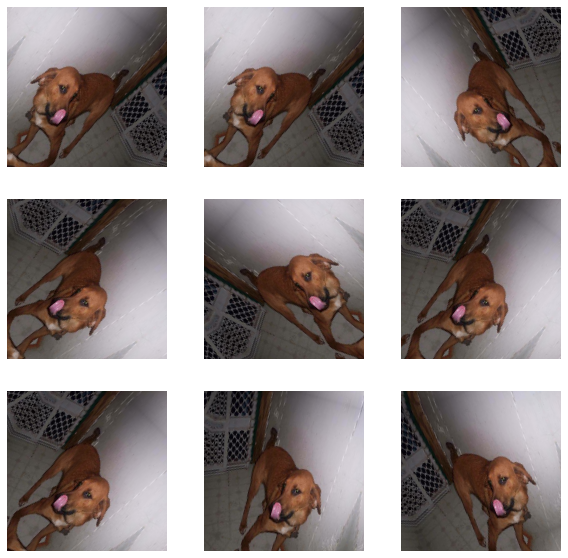

In [8]:
# Apply this layer to the same image a few times to see the result:

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10,10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale the pixel values
Right now, our pixel values are in the range of 0 to 255. The base model we will use for transfer learning expects values in the range -1 to 1. We will therefore use the preprocessing included with the model.

The model we will use is the __MobileNetV2__ model.

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1/127.5, offset = -1)

## Create the base model from the pre-trained covnets

The __ModileNet V2__ was developed at google and it is trained on 1.4M images, containing 1000 classes. 

We first need to pick a layer that we will use for feature extraction. The very last layer will not be useful to us. Instead we choose the _bottleneck layer_, which is the last layer before the flatten operation. The bottleneck layer features retain more generality.

By specifying `include_top=False`, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [10]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [11]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [12]:
# The base model converts each 160x160x3 image into a 5x5x1280 block of features:

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 5, 5, 1280)


## Freeze the convolutional base

By setting `layer.trainable = False` we are able to freeze the weights in a layer which prevents them from being updated druing training. Since our base model has many layers, we can conveniently set the entire model's `trainable` flag to `False`. 

In [13]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

## Add a clasification head 

Recall that a feature batch, after a forward pass in the base model has the shape (32, 5, 5, 1280). The generate predictions from the block of features, we will average over the spatial 5x5 spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D()` layer to convert the feature to a single 1280-element vector per image. 

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a dense layer to convert these features into a single prediction per image. We do not need an activation function here because this prediction will be treated as a `logit`. Positive numbers predict class 1, negative numbers predict class 0.
 

In [15]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 1)


We will now chain together the data_augmentation, rescaling, base_model and feature extractor layers to build a model. 

In [16]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

## Compile the model
Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output. 

In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

Note that there are 1281 trainable parameters, while about 2.5M parameters from the base are frozen. The trainable parameters are in the dense layer (weights and biases). 

In [18]:
len(model.trainable_variables)

2

## Train the model

In [19]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

32/32 [==============================] - 4s 59ms/step - loss: 0.8052 - accuracy: 0.5172


In [20]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:0.2f}".format(accuracy0))

initial loss: 0.81
initial accuracy: 0.51


In [21]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 10s 109ms/step - loss: 0.6833 - accuracy: 0.5920 - val_loss: 0.5486 - val_accuracy: 0.6800
Epoch 2/10
63/63 [==============================] - 6s 93ms/step - loss: 0.5069 - accuracy: 0.7140 - val_loss: 0.4013 - val_accuracy: 0.7930
Epoch 3/10
63/63 [==============================] - 6s 90ms/step - loss: 0.4257 - accuracy: 0.7865 - val_loss: 0.3122 - val_accuracy: 0.8590
Epoch 4/10
63/63 [==============================] - 6s 91ms/step - loss: 0.3586 - accuracy: 0.8220 - val_loss: 0.2547 - val_accuracy: 0.8860
Epoch 5/10
63/63 [==============================] - 6s 92ms/step - loss: 0.3049 - accuracy: 0.8560 - val_loss: 0.2156 - val_accuracy: 0.9110
Epoch 6/10
63/63 [==============================] - 6s 92ms/step - loss: 0.2764 - accuracy: 0.8810 - val_loss: 0.1893 - val_accuracy: 0.9210
Epoch 7/10
63/63 [==============================] - 6s 91ms/step - loss: 0.2614 - accuracy: 0.8850 - val_loss: 0.1687 - val_accuracy: 0.9280
Epoch 8/10


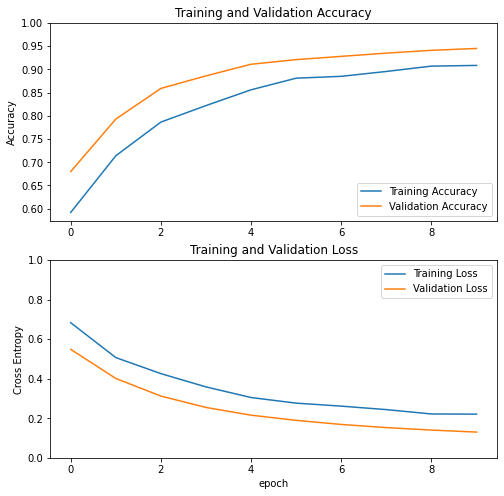

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
val_acc[-1], acc[-1]

(0.9449999928474426, 0.9085000157356262)

In [25]:
val_loss[-1], loss[-1]

(0.1301136463880539, 0.22089138627052307)

## Fine tuning
Above we did not update the weights of the MobileNet V2 model during training. One way of increasing performance of our model is to "fine tune" the weights of the top layers of the pre-trained model. This way our model is forced to recognize features associated  with our dataset, rather than generic features. 

### Un-freeze the top layers of the model

In [28]:
base_model.trainable = True

print(f'Number of layers in the base model: {len(base_model.layers)}')

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model: 154


### Compile the model
Since we will train a much larger model it is very importan to decrease the learning rate in order to avoid overfitting. 

In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [31]:
len(model.trainable_variables)

56

### Continue training the model


In [34]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 12s 119ms/step - loss: 0.1738 - accuracy: 0.9197 - val_loss: 0.0601 - val_accuracy: 0.9850
Epoch 11/20
63/63 [==============================] - 7s 104ms/step - loss: 0.1313 - accuracy: 0.9509 - val_loss: 0.0455 - val_accuracy: 0.9850
Epoch 12/20
63/63 [==============================] - 7s 102ms/step - loss: 0.1047 - accuracy: 0.9526 - val_loss: 0.0540 - val_accuracy: 0.9860
Epoch 13/20
63/63 [==============================] - 7s 103ms/step - loss: 0.1194 - accuracy: 0.9516 - val_loss: 0.0470 - val_accuracy: 0.9860
Epoch 14/20
63/63 [==============================] - 7s 105ms/step - loss: 0.0841 - accuracy: 0.9647 - val_loss: 0.0357 - val_accuracy: 0.9850
Epoch 15/20
63/63 [==============================] - 7s 103ms/step - loss: 0.0926 - accuracy: 0.9640 - val_loss: 0.0534 - val_accuracy: 0.9850
Epoch 16/20
63/63 [==============================] - 7s 104ms/step - loss: 0.0853 - accuracy: 0.9662 - val_loss: 0.0371 - val_accuracy: 0.988

In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

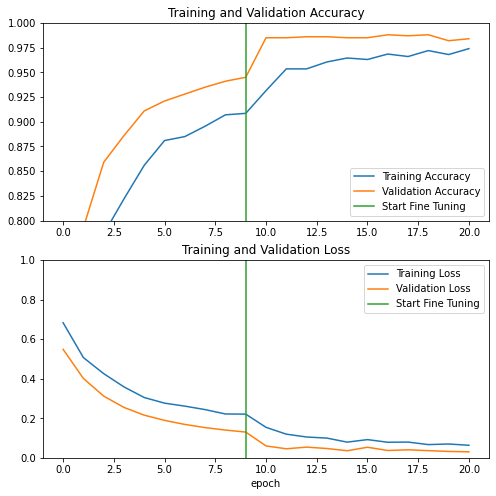

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [37]:
loss, accuracy = model.evaluate(test_dataset)
print(f'Test accuracy: {accuracy}')

6/6 [==============================] - 1s 75ms/step - loss: 0.0225 - accuracy: 0.9792
Test accuracy: 0.9791666865348816


Predictions: 
 [1 1 0 0 1 1 1 1 0 1 1 0 0 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 1 1]
Labels: 
 [1 1 0 0 1 1 1 1 0 1 1 0 0 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 1 1]


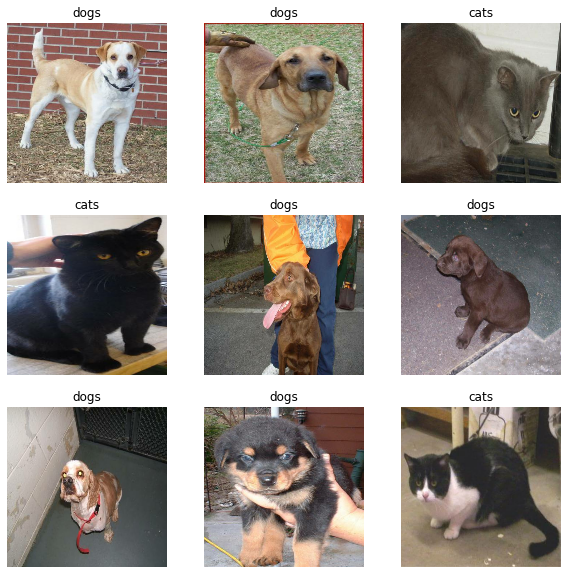

In [40]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions: \n', predictions.numpy())
print('Labels: \n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")